# Compare Temperature and Salinity from ACCESS-OM2 to WOA13

This notebook shows examples of comparing ACCESS-OM2 Temperature and Salinity structure to the WOA13 climatology (that is used as initial conditions for most runs). We describe the location and setup of the WOA13 data interpolated onto the model grids, as well as plot SST and SSS anomalies along with equatorial slices of temperature and salinity anomalies.

First, lets load in some modules, call some workers and load a database

In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cftime
import datetime
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import sys, os, warnings
import cosima_cookbook as cc
from dask.distributed import Client

from intake import cat
from datatree import DataTree, map_over_subtree

from datetime import timedelta
import cf_xarray as cfxr
import xesmf
warnings.filterwarnings('ignore')

In [2]:
client = Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/45359/status,
Dashboard: /proxy/45359/status,Workers: 14
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42473,Workers: 14
Dashboard: /proxy/45359/status,Total threads: 14
Started: Just now,Total memory: 63.00 GiB
Comm: tcp://127.0.0.1:36905,Total threads: 1
Dashboard: /proxy/34843/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:45111,


In [3]:
session_cc = cc.database.create_session()

## WOA13 data

The WOA13 data has already been interpolated onto the various model grids (as it is used for initial conditions). This makes it easy to plot biases.

The WOA13 data is located in the `/g/data/hh5/tmp/cosima/woa13/` folder, with various subfolders for the different resolutions (including the different vertical grids such as KDS50, KDS75 etc.). The available interpolated versions are (see `/g/data/hh5/tmp/cosima/woa13/README/`:

- `woa13/10` - 1-degree, GFDL50 vertical levels scheme
- `woa13/025` - 1/4-degree, GFDL50 vertical levels scheme
- `woa13/01` - 1/10-degree, KDS75 vertical levels scheme
- `woa13/10_KDS50` - 1-degree, KDS50 vertical levels scheme
- `woa13/025_KDS50` - 1/4-degree, KDS50 vertical levels scheme

Note that the new ACCESS-OM2 runs all use the KDS vertical levels schemes (KDS50 at 1-degree and 1/4-degree, KDS75 at 1/10-degree).

Let's first explore some of this data by looking at the 1-degree KDS50 experiment. First the netcdf files. Note that currently, because of the folder structure of the WOA13 data, the experiment names can be a bit opaque as they do not contain the woa13 string. Here we examine the 1-degree KDS50 data

In [4]:
# Create a new WOA database:

db = 'woa13.db'
session_woa = cc.database.create_session(db)

In [5]:
directory_list=['/g/data/hh5/tmp/cosima/woa13/10',
                '/g/data/hh5/tmp/cosima/woa13/025',
                '/g/data/hh5/tmp/cosima/woa13/01',
                '/g/data/hh5/tmp/cosima/woa13/10_KDS50',
                '/g/data/hh5/tmp/cosima/woa13/10_KDS75',
                '/g/data/hh5/tmp/cosima/woa13/025_KDS50'
               ]

cc.database.build_index(directory_list, session_woa)

Indexing experiment: 10
Indexing experiment: 025
Indexing experiment: 01
Indexing experiment: 10_KDS50
Indexing experiment: 10_KDS75
Indexing experiment: 025_KDS50


0

## Comparing to ACCESS-OM2 simulations

Now lets plot some biases against the WOA13 data set. We will use the original ACCESS-OM2 IAF runs, so first define a dictionary with information on those runs

In [6]:
from collections import OrderedDict
exptdict = OrderedDict([
    ('1degIAF', # 1deg IAF run from Kiss et al. 2020
     {'model': 'ACCESS-OM2 IAF', 'expt': '1deg_jra55v13_iaf_spinup1_B1',
      'n_files': -12, 'itime': '1998-01-01', 'ftime': None}),
    ('025degIAF', # 025deg IAF run from Kiss et al. 2020
     {'model': 'ACCESS-OM2-025 IAF', 'expt': '025deg_jra55v13_iaf_gmredi6',
      'n_files': -34, 'itime': '1998-01-01', 'ftime': None}),
    ('01degIAF', # 01deg IAF run from Kiss et al. 2020
     {'model': 'ACCESS-OM2-01 IAF',  'expt': '01deg_jra55v13_iaf',
      'n_files': None, 'itime': '1998-01-01','ftime': None})
])

For each of these runs we then attach information to these dictionaries containing the matched WOA13 interpolated data sets. Note that we include a file name (with wildcards) so that we only use the monthly files and not the additional `ocean_temp_salt.res.nc` initial condition file.

In [7]:
# Add on pre-interpolated WOA13 directories for every run:
for ekey in exptdict.keys():
    e = exptdict[ekey]
    if (ekey.find('025deg') != -1):
        e['WOA13expt'] = '025_KDS50'
        e['WOA13file'] = 'woa13_ts_??_mom025.nc'
    elif (ekey.find('01deg') != -1):
        e['WOA13expt'] = '01'
        e['WOA13file'] = 'woa13_ts_??_mom01.nc'
    else:
        e['WOA13expt'] = '10_KDS50'
        e['WOA13file'] = 'woa13_ts_??_mom10.nc'

In [8]:
# catalog[RUNS["ACCESS-OM2-10 JRA55-do IAF OMIP2"][0]]
tmp_datastore = catalog["025deg_jra55_iaf_omip2_cycle1"].search(variable="sst", frequency='1mon')
tmp_datastore
tmp_datastore.to_dataset_dict(progressbar=False)

NameError: name 'catalog' is not defined

## SST and SSS biases

We will start by plotting SST and SSS biases compared to WOA13. The following loop loads data from the model runs and the corresponding WOA13 data and saves them into the previous dictionary (as entries SST, SST_WOA13 and SST_anom and the same for SSS). This can take time...

In [9]:
%%time
# RUNS = {
#     "ACCESS-OM2-10 JRA55-do IAF OMIP2": ["1deg_jra55_iaf_omip2_cycle1"], # (our name: run name(s))
#     "ACCESS-OM2-10 JRA55-do RYF [dev]": ["1deg_jra55do_ryf"],
#     # "ACCESS-OM3-10 JRA55-do RYF [test]": ["my_1deg_jra55do_ryf_experiment_name"],
# }
RUN_DICT = {
    # "ACCESS-OM2-10 JRA55-do IAF OMIP2": {"expt": "1deg_jra55_iaf_omip2_cycle1", "model": "access-om2"},
    "ACCESS-OM2-10 JRA55-do RYF [dev]": {"expt": "1deg_jra55_ryf-expt-054ea9ee", "model": "access-om2-dev"},
    "ACCESS-OM2-10 JRA55-do IAF [dev]": {"expt": "1deg_jra55_iaf-expt-70159801", "model": "access-om2-dev"},
    "ACCESS-OM3-10 JRA55-do RYF [dev]": {"expt": "1deg_jra55do_iaf", "model": "access-om3-dev"},
    "ACCESS-OM3-10 JRA55-do IAF [dev]": {"expt": "1deg_jra55do_ryf", "model": "access-om3-dev"},
}
VARS = ["tos", "hi_m" ]  # ice area fraction or sea ice concentration, ice thickness averaged by grid cell area
VARS_2D = ["area_t", "geolat_t", "geolon_t"]

catalog = cat.access_nri

def open_by_name(name, vars):
    """Return a dataset for the requested name and vars"""
    return (
        catalog[name]
        .search(variable=vars)
        .to_dask(
            xarray_open_kwargs={
                "chunks": {"time": "auto", "ni": -1, "nj": -1},
                "decode_coords": False,
            },
            xarray_combine_by_coords_kwargs={
                "compat": "override",
                "data_vars": "minimal",
                "coords": "minimal",
            },
        )
    )
    
def open_by_experiment(exp_name, vars):
    """Concatenate any datasets provided for this experiment into one ds, and add area and geo coordinates"""
    if RUN_DICT[exp_name]["model"] in ["access-om2", "access-om3"]:
        # If the experiment is in the Catalog then get the data from there
        # get the data for each run of this config
        mom6_ds = xr.concat(
            [open_by_name(iName, vars) for iName in [RUN_DICT[exp_name]['expt']]], dim="time"
        )
    
        # We also want the area/lat/lon fields, but these are not time dependent.
        area_ds = xr.merge(
            [
                xr.open_dataset(
                    catalog[RUN_DICT[exp_name]['expt']]
                    .search(variable=iVar)
                    .df.path[0]
                    # path of the first file with the area field, the geolon field and the geolat field
                ).drop_vars("time")
                for iVar in VARS_2D
            ]
        )
    
        # Label the lats and lons
        mom6_ds.coords["ni"] = area_ds["xt_ocean"].values
        mom6_ds.coords["nj"] = area_ds["yt_ocean"].values
    
        # Copy attributes for cf compliance
        mom6_ds.ni.attrs = area_ds.xt_ocean.attrs
        mom6_ds.nj.attrs = area_ds.yt_ocean.attrs
    
        mom6_ds = cice_ds.rename(({"ni": "xt_ocean", "nj": "yt_ocean"}))
    
        # Add the geolon, geolat, and area as extra co-ordinates fields from area_t
    
        mom6_ds = cice_ds.assign_coords(
            {
                "geolat_t": area_ds.geolat_t,
                "geolon_t": area_ds.geolon_t,
                "area_t": area_ds.area_t,
            }
        )
    
        # cice timestamps are also misleading:
        # mom6_ds["time"] = cice_ds.time.to_pandas() - timedelta(minutes=1)
    elif RUN_DICT[exp_name]["model"] == "access-om2-dev":
        # Else, it is a development expt and stored on ps29
        base_dir = f"/scratch/ps29/nd0349/{exp_name[0:10].lower()}/archive/{RUN_DICT[exp_name]['expt']}/"
        output_dirs = glob.glob(os.path.join(base_dir, "output[0-9][0-9][0-9]"))
        
        # Extract most recent simulation
        if output_dirs:
            output_number = max(int(d[-3:]) for d in output_dirs)  # Extract last 3 digits
            output_number = f"{output_number:03d}"  # Ensure it stays in 000 format
        else:
            output_number = "000"  # Default if no directories exist
        # print(output_number)
        path = os.path.join(base_dir, f"output{output_number}", "ocean/")
        file_pattern = os.path.join(path, "ocean-2d-surface_pot_temp-1-monthly-mean-ym_????_??.nc")
        # print(file_pattern)
        files = sorted(glob.glob(file_pattern))
        # print(files)
        file_list = sorted(glob.glob(file_pattern))
        
        # Read in data
        mom6_ds = xr.open_mfdataset(file_list, combine="by_coords")
        mom6_ds["tos"] = mom6_ds["surface_pot_temp"] - 273.15 # Converting to deg. C
        # We also want the area/lat/lon fields, but these are not time dependent.
        area_ds = xr.open_mfdataset("/g/data/vk83/configurations/inputs/access-om3/cice/grids/global.1deg/2024.05.14/grid.nc", 
                                    combine="by_coords")
        # area_ds = area_ds.rename(({"ni": "xt_ocean", "nj": "yt_ocean", "tarea": "area_t", "tlat": "geolat_t", "tlon": "geolon_t"}))
        # VARS_2D = ["area_t", "geolat_t", "geolon_t"]
        # VARS_2D = ["area_t", "geolat_t", "geolon_t"]
        
        # # Label the lats and lons
        # mom6_ds.coords["ni"] = area_ds["xt_ocean"].values
        # mom6_ds.coords["nj"] = area_ds["yt_ocean"].values
        
        # # Copy attributes for cf compliance
        # mom6_ds.ni.attrs = area_ds.xt_ocean.attrs
        # mom6_ds.nj.attrs = area_ds.yt_ocean.attrs
        
        # mom6_ds = mom6_ds.rename(({"ni": "xt_ocean", "nj": "yt_ocean"}))
        
        # # Add the geolon, geolat, and area as extra co-ordinates fields from area_t
        
        # mom6_ds = mom6_ds.assign_coords(
        #     {
        #         "geolat_t": area_ds.geolat_t,
        #         "geolon_t": area_ds.geolon_t,
        #         "area_t": area_ds.area_t,
        #     }
        # )
        
        # cice timestamps are also misleading:
        # cice_ds["time"] = cice_ds.time.to_pandas() - timedelta(minutes=1)

    elif RUN_DICT[exp_name]["model"] == "access-om3-dev":
        print(RUN_DICT[exp_name]["model"])
        # Else, it is a development expt and stored on ps29
        most_recent_file = True
        run_status = 'archive' # 'archive' or 'work'
        if run_status == 'work':
            print("Using work directory")
            base_dir = f"/scratch/ps29/nd0349/{exp_name[0:10].lower()}/work/{RUN_DICT[exp_name]['expt']}/"
            file_pattern = os.path.join(base_dir, "access-om3.cice.1mon.mean.????-??.nc")
            print(file_pattern)
        else:
        
            base_dir = f"/scratch/ps29/nd0349/{exp_name[0:10].lower()}/archive/{RUN_DICT[exp_name]['expt']}/"
            output_dirs = glob.glob(os.path.join(base_dir, "output[0-9][0-9][0-9]"))
        
            # Extract most recent simulation
            if output_dirs:
                output_number = max(int(d[-3:]) for d in output_dirs)  # Extract last 3 digits
                output_number = f"{output_number:03d}"  # Ensure it stays in 000 format
            else:
                output_number = "000"  # Default if no directories exist
            
            file_pattern = os.path.join(base_dir, f"output{output_number}", "access-om3.mom6.h.sfc????_??.nc")
            print(file_pattern)
            
        if most_recent_file:
            print(f"Output folder: {output_number}")
            files = sorted(glob.glob(file_pattern))
        else:
            all_files = []
            for output_dir in output_dirs:
                file_pattern = os.path.join(output_dir, "access-om3.mom6.h.sfc????_??.nc")
                all_files.extend(glob.glob(file_pattern))
            files = sorted(all_files)
        
        print(files)
        
        # Read in data
        mom6_ds = xr.open_mfdataset(files, combine="by_coords")
        # mom6_ds = xr.open_mfdataset(files)
        # print("read in mom data")
        # We also want the area/lat/lon fields, but these are not time dependent.
        # area_ds = xr.open_mfdataset("/g/data/vk83/configurations/inputs/access-om3/cice/grids/global.1deg/2024.05.14/grid.nc", 
                                    # combine="by_coords")
        # area_ds = area_ds.rename(({"ni": "xt_ocean", "nj": "yt_ocean", "tarea": "area_t", "tlat": "geolat_t", "tlon": "geolon_t"}))
        # VARS_2D = ["area_t", "geolat_t", "geolon_t"]
        # VARS_2D = ["area_t", "geolat_t", "geolon_t"]
        # print("read in area data")
        # Label the lats and lons
        # mom6_ds.coords["ni"] = area_ds["xt_ocean"].values
        # mom6_ds.coords["nj"] = area_ds["yt_ocean"].values
        
        # Copy attributes for cf compliance
        # mom6_ds.ni.attrs = area_ds.xt_ocean.attrs
        # mom6_ds.nj.attrs = area_ds.yt_ocean.attrs
        
        # mom6_ds = mom6_ds.rename(({"ni": "xt_ocean", "nj": "yt_ocean"}))
        mom6_ds = mom6_ds.rename({'xh': 'xt_ocean', 'yh': 'yt_ocean'})
        
        # Add the geolon, geolat, and area as extra co-ordinates fields from area_t
        
        # mom6_ds = mom6_ds.assign_coords(
        #     {
        #         "geolat_t": area_ds.geolat_t,
        #         "geolon_t": area_ds.geolon_t,
        #         "area_t": area_ds.area_t,
        #     }
        # )
        # print("fixed coords")
        # cice timestamps are also misleading:
        # mom6_ds["time"] = mom6_ds.time.to_pandas() - timedelta(minutes=1)

    elif RUN_DICT[exp_name]["model"] == "access-om3-wav-dev":
        # ACCESS-OM3 development
        base_dir = f"/scratch/ps29/nd0349/{exp_name[0:10].lower()}/archive/{RUN_DICT[exp_name]['expt']}/"
        output_dirs = glob.glob(os.path.join(base_dir, "output[0-9][0-9][0-9]"))
        
        # # Extract most recent simulation
        # if output_dirs:
        #     output_number = max(int(d[-3:]) for d in output_dirs)  # Extract last 3 digits
        #     output_number = f"{output_number:03d}"  # Ensure it stays in 000 format
        # else:
        #     output_number = "000"  # Default if no directories exist
        
        # path = os.path.join(base_dir, f"output{output_number}")
        # file_pattern = os.path.join(path, "access-om3.cice.*.nc")
        # files = sorted(glob.glob(file_pattern))
        # file_list = sorted(glob.glob(file_pattern))

        file_pattern = os.path.join(base_dir, "output[0-9][0-9][0-9]", "access-om3.cice.*.nc")
        file_list = sorted(glob.glob(file_pattern))
        print(file_list)
        # Read in data
        if file_list:
            cice_ds = xr.open_mfdataset(file_list, combine="by_coords")
        else:
            print("No matching files found.")


        # Read in data
        # cice_ds = xr.open_mfdataset(file_list, combine="by_coords")
        # cice_ds['aice_m'] = cice_ds['aice'].resample(time='ME').max()
        cice_ds['aice_m'] = cice_ds['aice']
        area_ds = xr.open_mfdataset("/g/data/vk83/configurations/inputs/access-om3/cice/grids/global.1deg/2024.05.14/grid.nc", 
                                    combine="by_coords")
        area_ds = area_ds.rename(({"ni": "xt_ocean", "nj": "yt_ocean", "tarea": "area_t", "tlat": "geolat_t", "tlon": "geolon_t"}))
        # VARS_2D = ["area_t", "geolat_t", "geolon_t"]
        
        # Label the lats and lons
        cice_ds.coords["ni"] = area_ds["xt_ocean"].values
        cice_ds.coords["nj"] = area_ds["yt_ocean"].values
        
        # Copy attributes for cf compliance
        cice_ds.ni.attrs = area_ds.xt_ocean.attrs
        cice_ds.nj.attrs = area_ds.yt_ocean.attrs
        
        cice_ds = cice_ds.rename(({"ni": "xt_ocean", "nj": "yt_ocean"}))
        
        # Add the geolon, geolat, and area as extra co-ordinates fields from area_t
        
        cice_ds = cice_ds.assign_coords(
            {
                "geolat_t": area_ds.geolat_t,
                "geolon_t": area_ds.geolon_t,
                "area_t": area_ds.area_t,
            }
        )
        
        # cice timestamps are also misleading:
        cice_ds["time"] = cice_ds.time.to_pandas() - timedelta(minutes=1)
    return mom6_ds




CPU times: user 394 ms, sys: 92.2 ms, total: 486 ms
Wall time: 904 ms


In [10]:
%%time

si_name_ds_pairs = [(iRun, open_by_experiment(iRun, VARS)) for iRun in RUN_DICT.keys()]

si_dt = DataTree.from_dict(dict(si_name_ds_pairs))

access-om3-dev
/scratch/ps29/nd0349/access-om3/archive/1deg_jra55do_iaf/output007/access-om3.mom6.h.sfc????_??.nc
Output folder: 007
['/scratch/ps29/nd0349/access-om3/archive/1deg_jra55do_iaf/output007/access-om3.mom6.h.sfc1965_01.nc', '/scratch/ps29/nd0349/access-om3/archive/1deg_jra55do_iaf/output007/access-om3.mom6.h.sfc1965_02.nc', '/scratch/ps29/nd0349/access-om3/archive/1deg_jra55do_iaf/output007/access-om3.mom6.h.sfc1965_03.nc', '/scratch/ps29/nd0349/access-om3/archive/1deg_jra55do_iaf/output007/access-om3.mom6.h.sfc1965_04.nc', '/scratch/ps29/nd0349/access-om3/archive/1deg_jra55do_iaf/output007/access-om3.mom6.h.sfc1965_05.nc', '/scratch/ps29/nd0349/access-om3/archive/1deg_jra55do_iaf/output007/access-om3.mom6.h.sfc1965_06.nc', '/scratch/ps29/nd0349/access-om3/archive/1deg_jra55do_iaf/output007/access-om3.mom6.h.sfc1965_07.nc', '/scratch/ps29/nd0349/access-om3/archive/1deg_jra55do_iaf/output007/access-om3.mom6.h.sfc1965_08.nc', '/scratch/ps29/nd0349/access-om3/archive/1deg_jra5

In [11]:
si_dt

DataTree('None', parent=None)
├── DataTree('ACCESS-OM2-10 JRA55-do RYF [dev]')
│       Dimensions:           (time: 60, yt_ocean: 300, xt_ocean: 360, nv: 2)
│       Coordinates:
│         * xt_ocean          (xt_ocean) float64 3kB -279.5 -278.5 -277.5 ... 78.5 79.5
│         * yt_ocean          (yt_ocean) float64 2kB -77.88 -77.63 ... 89.32 89.77
│         * time              (time) object 480B 1950-01-16 12:00:00 ... 1954-12-16 1...
│         * nv                (nv) float64 16B 1.0 2.0
│       Data variables:
│           surface_pot_temp  (time, yt_ocean, xt_ocean) float32 26MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
│           average_T1        (time) datetime64[ns] 480B dask.array<chunksize=(12,), meta=np.ndarray>
│           average_T2        (time) datetime64[ns] 480B dask.array<chunksize=(12,), meta=np.ndarray>
│           average_DT        (time) timedelta64[ns] 480B dask.array<chunksize=(12,), meta=np.ndarray>
│           time_bnds         (time, nv) timedelta64[ns] 960B dask.array<chunksize=(1, 2), meta=np.ndarray>
│           tos               (time, yt_ocean, xt_ocean) float32 26MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
│       Attributes:
│           filename:   ocean-2d-surface_pot_temp-1-monthly-mean-ym_1950_01.nc
│           title:      ACCESS-OM2
│           grid_type:  mosaic
│           grid_tile:  1
├── DataTree('ACCESS-OM2-10 JRA55-do IAF [dev]')
│       Dimensions:           (time: 60, yt_ocean: 300, xt_ocean: 360, nv: 2)
│       Coordinates:
│         * xt_ocean          (xt_ocean) float64 3kB -279.5 -278.5 -277.5 ... 78.5 79.5
│         * yt_ocean          (yt_ocean) float64 2kB -77.88 -77.63 ... 89.32 89.77
│         * time              (time) datetime64[ns] 480B 2003-01-16T12:00:00 ... 2007...
│         * nv                (nv) float64 16B 1.0 2.0
│       Data variables:
│           surface_pot_temp  (time, yt_ocean, xt_ocean) float32 26MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
│           average_T1        (time) datetime64[ns] 480B dask.array<chunksize=(12,), meta=np.ndarray>
│           average_T2        (time) datetime64[ns] 480B dask.array<chunksize=(12,), meta=np.ndarray>
│           average_DT        (time) timedelta64[ns] 480B dask.array<chunksize=(12,), meta=np.ndarray>
│           time_bnds         (time, nv) timedelta64[ns] 960B dask.array<chunksize=(1, 2), meta=np.ndarray>
│           tos               (time, yt_ocean, xt_ocean) float32 26MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
│       Attributes:
│           filename:   ocean-2d-surface_pot_temp-1-monthly-mean-ym_2003_01.nc
│           title:      ACCESS-OM2
│           grid_type:  mosaic
│           grid_tile:  1
├── DataTree('ACCESS-OM3-10 JRA55-do RYF [dev]')
│       Dimensions:       (time: 365, yt_ocean: 300, xt_ocean: 360, xq: 361, yq: 301,
│                          nv: 2)
│       Coordinates:
│         * xt_ocean      (xt_ocean) float64 3kB -279.5 -278.5 -277.5 ... 77.5 78.5 79.5
│         * yt_ocean      (yt_ocean) float64 2kB -77.88 -77.63 -77.38 ... 89.32 89.77
│         * time          (time) datetime64[ns] 3kB 1964-12-30T12:00:00 ... 1965-12-2...
│         * nv            (nv) float64 16B 1.0 2.0
│         * xq            (xq) float64 3kB -280.0 -279.0 -278.0 ... 78.0 79.0 80.0
│         * yq            (yq) float64 2kB -78.0 -77.75 -77.51 ... 89.1 89.55 90.0
│       Data variables: (12/16)
│           SSH           (time, yt_ocean, xt_ocean) float32 158MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
│           tos           (time, yt_ocean, xt_ocean) float32 158MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
│           sos           (time, yt_ocean, xt_ocean) float32 158MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
│           SSU           (time, yt_ocean, xq) float32 158MB dask.array<chunksize=(1, 300, 361), meta=np.ndarray>
│           SSV           (time, yq, xt_ocean) float32 158MB dask.array<chunksize=(1, 301, 360), meta=np.ndarray>
│

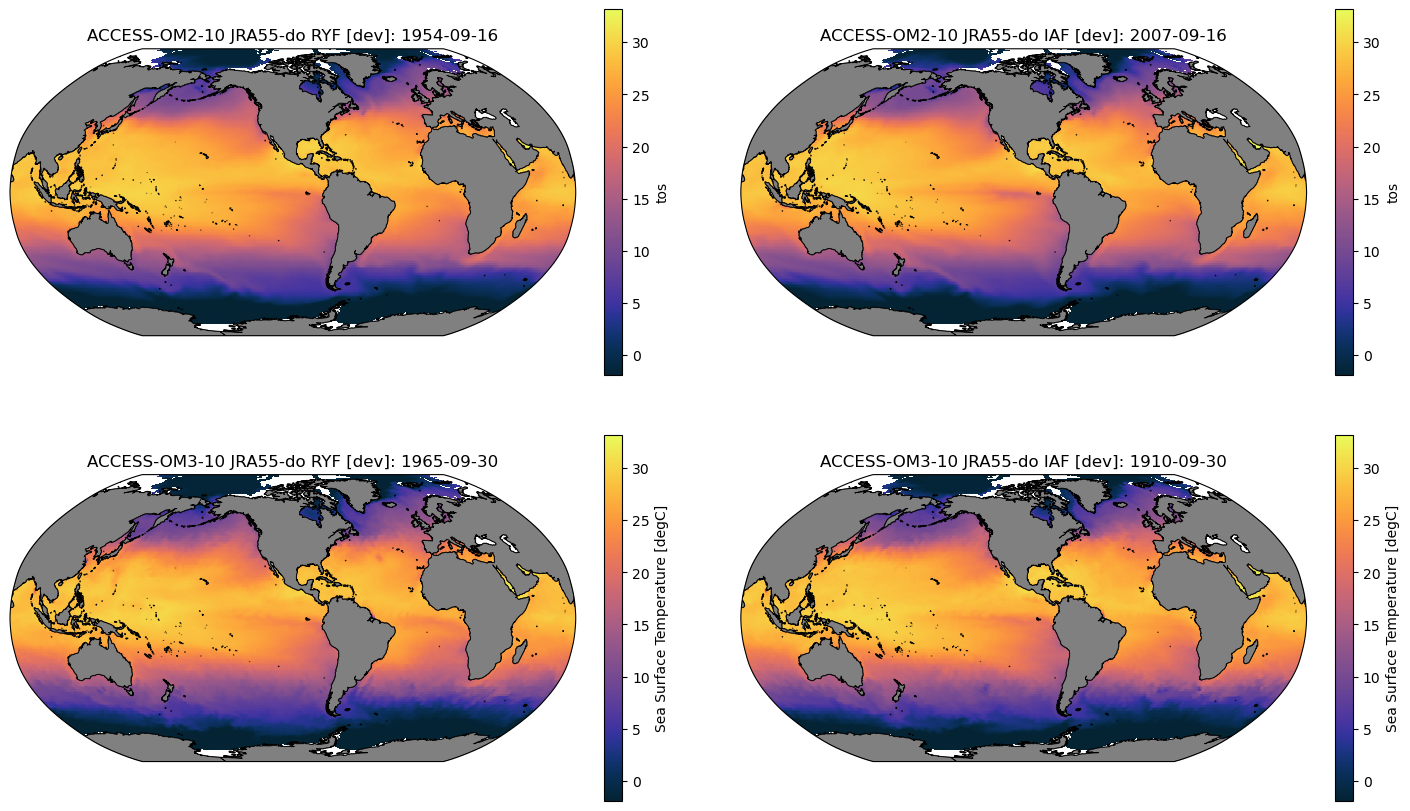

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cft
import cmocean.cm as cmo
import math

# Determine subplot layout (always 2 columns)
n_groups = len(si_dt.groups[1:])
ncols = 2
ncols = math.ceil(n_groups / ncols)
nrows = 2  # Ensures a balanced layout

# Create subplots with proper projection and improved spacing
fig, axes = plt.subplots(nrows=nrows, 
                         ncols=ncols,  
                         figsize=(14, 4 * nrows),  # Adjust height dynamically
                         constrained_layout=True,
                         subplot_kw={'projection': ccrs.Robinson(central_longitude=-100)},
                         gridspec_kw={'wspace': 0.1, 'hspace': 0.15})  # Adjust spacing

# Flatten axes for iteration safety
if nrows > 1:
    axes = axes.flatten()
else:
    axes = np.array([axes]).flatten()  # Ensure a consistent structure if `nrows == 1`

# Add coastlines and land features
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                   edgecolor='black',
                                   facecolor='gray', linewidth=0.5)

for ax in axes:
    ax.set_global()
    ax.coastlines(resolution='50m')
    ax.add_feature(land_50m)

# Find global min and max for consistent color scale
all_data = []
for iGroup in si_dt.groups[1:]:
    ds1 = si_dt[iGroup].ds
    closest_september_time1 = ds1.time.where(ds1.time.dt.month == 9, drop=True).isel(time=-1)
    data1 = ds1.sel(time=closest_september_time1)["tos"].squeeze()
    all_data.append(data1.values)

vmin = np.nanmin(all_data)
vmax = np.nanmax(all_data)

# Plot data with consistent color scale and add subplot labels
for i, iGroup in enumerate(si_dt.groups[1:]):
    if i >= len(axes):  # Safety check
        break

    ds1 = si_dt[iGroup].ds
    closest_september_time1 = ds1.time.where(ds1.time.dt.month == 9, drop=True).isel(time=-1)
    data1 = ds1.sel(time=closest_september_time1)["tos"].squeeze()

    # Plot with consistent vmin/vmax
    im = data1.plot.pcolormesh(ax=axes[i], cmap=cmo.thermal, transform=ccrs.PlateCarree(),
                               vmin=vmin, vmax=vmax, add_colorbar=True)
    axes[i].set_title(f"{iGroup[1:]}: {closest_september_time1.dt.strftime('%Y-%m-%d').values}")
plt.savefig("/home/566/nd0349/access-om3-analysis/figures/sst_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

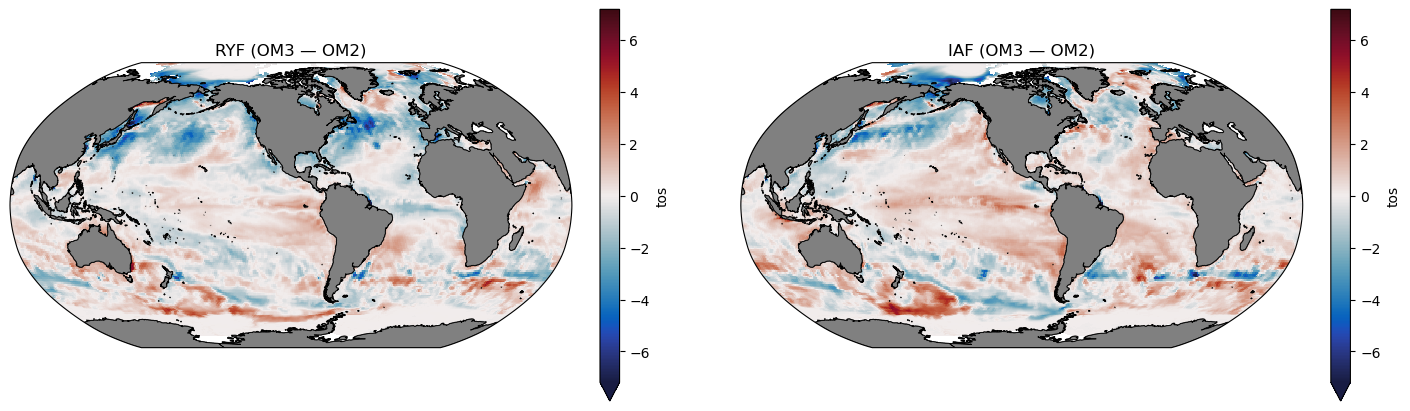

In [25]:
fig, axes = plt.subplots(nrows=1, 
                         ncols=ncols,  
                         figsize=(14, 4),  # Adjust height dynamically
                         constrained_layout=True,
                         subplot_kw={'projection': ccrs.Robinson(central_longitude=-100)},
                         gridspec_kw={'wspace': 0.1, 'hspace': 0.15})  # Adjust spacing

for ax in axes:
    ax.set_global()
    ax.coastlines(resolution='50m')
    ax.add_feature(land_50m)

diff_data = []
diff_data.append(all_data[2] - all_data[0])
diff_data.append(all_data[3] - all_data[1])


# diff_vmin = np.nanmin(diff_data)
diff_vmax = abs(np.nanmax(diff_data))

# Plot data with consistent color scale and add subplot labels
for i in range(2):

    ds1 = si_dt[list(RUN_DICT.keys())[i]].ds
    closest_september_time1 = ds1.time.where(ds1.time.dt.month == 9, drop=True).isel(time=-1)
    data1 = ds1.sel(time=closest_september_time1)["tos"].squeeze()

    ds2 = si_dt[list(RUN_DICT.keys())[i+2]].ds
    closest_september_time1 = ds2.time.where(ds2.time.dt.month == 9, drop=True).isel(time=-1)
    data2 = ds2.sel(time=closest_september_time1)["tos"].squeeze()

    # Plot with consistent vmin/vmax
    im = (data2-data1).plot.pcolormesh(ax=axes[i], cmap=cmo.balance, transform=ccrs.PlateCarree(),
                               vmin=-diff_vmax, vmax=diff_vmax, add_colorbar=True)

axes[0].set_title(f"RYF (OM3 — OM2)")
axes[1].set_title(f"IAF (OM3 — OM2)")
    
plt.savefig("/home/566/nd0349/access-om3-analysis/figures/sst_difference.png", dpi=300, bbox_inches="tight")
plt.show()

In [21]:
iGroup

'/ACCESS-OM3-10 JRA55-do IAF [dev]'

In [22]:
list(RUN_DICT.keys())

['ACCESS-OM2-10 JRA55-do RYF [dev]',
 'ACCESS-OM2-10 JRA55-do IAF [dev]',
 'ACCESS-OM3-10 JRA55-do RYF [dev]',
 'ACCESS-OM3-10 JRA55-do IAF [dev]']

In [104]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cft
import cmocean.cm as cmo
import math

# Determine subplot layout (always 2 columns)
n_groups = len(si_dt.groups[1:])
ncols = math.ceil(n_groups / ncols)
nrows = 2  # Ensures a balanced layout

# Create subplots with proper projection and improved spacing
fig, axes = plt.subplots(nrows=nrows, 
                         ncols=ncols,  
                         figsize=(14, 4 * nrows),  # Adjust height dynamically
                         constrained_layout=True,
                         subplot_kw={'projection': ccrs.Robinson(central_longitude=-100)},
                         gridspec_kw={'wspace': 0.1, 'hspace': 0.15})  # Adjust spacing

# Flatten axes for iteration safety
if nrows > 1:
    axes = axes.flatten()
else:
    axes = np.array([axes]).flatten()  # Ensure a consistent structure if `nrows == 1`

# Add coastlines and land features
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                   edgecolor='black',
                                   facecolor='gray', linewidth=0.5)

for ax in axes:
    ax.set_global()
    ax.coastlines(resolution='50m')
    ax.add_feature(land_50m)

# Find global min and max for consistent color scale
all_data = []
for iGroup in si_dt.groups[1:]:
    ds1 = si_dt[iGroup].ds
    closest_september_time1 = ds1.time.where(ds1.time.dt.month == 9, drop=True).isel(time=-1)
    data1 = ds1.sel(time=closest_september_time1)["tos"].squeeze()
    all_data.append(data1.values)

vmin = np.nanmin(all_data)
vmax = np.nanmax(all_data)

# Plot data with consistent color scale and add subplot labels
for i, iGroup in enumerate(si_dt.groups[1:]):
    if i >= len(axes):  # Safety check
        break

    ds1 = si_dt[iGroup].ds
    closest_september_time1 = ds1.time.where(ds1.time.dt.month == 9, drop=True).isel(time=-1)
    data1 = ds1.sel(time=closest_september_time1)["tos"].squeeze()

    # Plot with consistent vmin/vmax
    im = data1.plot.pcolormesh(ax=axes[i], cmap=cmo.thermal, transform=ccrs.PlateCarree(),
                               vmin=vmin, vmax=vmax, add_colorbar=True)
    axes[i].set_title(f"{iGroup[1:]}: {closest_september_time1.dt.strftime('%Y-%m-%d').values}")
plt.savefig("/home/566/nd0349/access-om3-analysis/figures/sst_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

'ACCESS-OM3-10 JRA55-do IAF [dev]'

In [88]:
data1
# data2.values

<xarray.DataArray 'surface_pot_temp' (yt_ocean: 300, xt_ocean: 360)>
dask.array<getitem, shape=(300, 360), dtype=float32, chunksize=(300, 360), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yt_ocean  (yt_ocean) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
    time      datetime64[ns] 2003-09-16
Attributes:
    long_name:      Potential temperature
    units:          K
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature

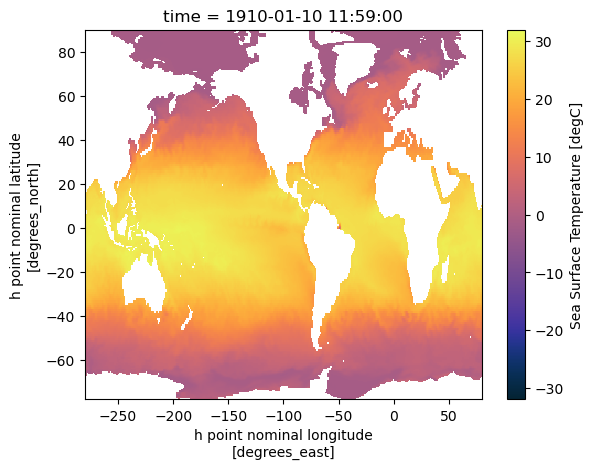

In [17]:
si_dt['ACCESS-OM3-10 JRA55-do RYF [dev]'].ds.isel(time=9)["tos"].plot(cmap=cmo.thermal)

In [ ]:
surface_temp
# si_dt
RUNS.keys()
si_dt

In [34]:
import warnings
warnings.simplefilter("ignore", UserWarning)

In [57]:
# Function to extract and load SST and SSS from the models, WOA13
ekeys = ['1degIAF', '025degIAF', '01degIAF']
for ekey in ekeys:
    e = exptdict[ekey]
    
    # SST
    
    # Load surface temperature from model
    surface_temp = cc.querying.getvar(e['expt'], 'temp', session_cc,
                                      n=e['n_files'], ncfile='ocean.nc',
                                      start_time=e['itime'], end_time=e['ftime']).isel(st_ocean=0)

    # convert MOM time to datetime:
    tstart = datetime.datetime.fromtimestamp(surface_temp.time.item(0) * 1e-9)
    tend = datetime.datetime.fromtimestamp(surface_temp.time.item(-1) * 1e-9)
    
    # Extract a year range string and print (for title string):
    e['yearrange'] = "{} to {}".format(tstart.strftime("%Y-%m"), tend.strftime("%Y-%m"),)
    print(f"{ekey}: {e['yearrange']}")
    
    # Add SST to dictionary
    e['SST'] = surface_temp.mean('time').load() - 273.15
    
    # Load WOA13 SST and add to dictionary
    # ignore warning about ambiguous files
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning)
        e['SST_WOA13'] = cc.querying.getvar(e['WOA13expt'], 'temp', session_woa).isel(ZT=0).mean('time').load()
    
    # Calculate bias and add to dictionary
    SST_anom = e['SST'] - e['SST_WOA13'].values 
    e['SST_anom'] = SST_anom.load()
    
    # SSS
    surface_salt = cc.querying.getvar(e['expt'], 'salt', session_cc,
                                      n=e['n_files'],ncfile='ocean.nc',
                                      start_time=e['itime'], end_time=e['ftime']).isel(st_ocean=0)
    e['SSS'] = surface_salt.mean('time').load()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning)
        e['SSS_WOA13'] = cc.querying.getvar(e['WOA13expt'], 'salt', session_woa).isel(ZT=0).mean('time').load()

    SSS_anom = e['SSS'] - e['SSS_WOA13'].values 
    e['SSS_anom'] = SSS_anom.load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3

1degIAF: 2198-07 to 2257-07


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/coding/times.py:987: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/coding/times.py:987: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/indexing.py:525: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(se

025degIAF: 2198-06 to 2257-06


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/coding/times.py:987: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/coding/times.py:987: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/indexing.py:525: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(se

01degIAF: 1998-01 to 2017-12


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/coding/times.py:987: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/coding/times.py:987: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/coding/times.py:987: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_da

Now that all the data is loaded, all we have to do is plot it.

We first define a function to plot the SST

In [35]:
def plot_SST(ekeys):
    clev = np.arange(-3, 3.25, 0.25)
    land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                       edgecolor='black',
                                       facecolor='gray', linewidth=0.5)

    for i, ekey in enumerate(ekeys):
        e = exptdict[ekey]
        ax1 = plt.subplot(1+len(ekeys)//2, 2, i+1,
                          projection=ccrs.Robinson(central_longitude=-100))
        ax1.coastlines(resolution='50m')
        ax1.add_feature(land_50m)
        pn = e['SST_anom'].plot.contourf(cmap=cm.cm.balance, levels=clev,
                                        add_colorbar=False, transform=ccrs.PlateCarree())
        plt.title("({}) {}, {}".format(chr(ord('a') + i), e['model'], e['yearrange']))

        if i == 0:#1:
            # save plot for colourbar
            p0 = pn

    i = i+1
    e = exptdict['01degIAF']
    ax1 = plt.subplot(1+len(ekeys)//2, 2, i+1,
                      projection=ccrs.Robinson(central_longitude=-100))
    ax1.coastlines(resolution='50m')
    ax1.add_feature(land_50m)
    pn = e['SST_WOA13'].plot.contourf(cmap=cm.cm.thermal, levels=np.arange(-2., 32., 1.),
                                      add_colorbar=False, transform=ccrs.PlateCarree())
    plt.title("({}) WOA13".format(chr(ord('a') + i)))

    ax5 = plt.axes([0.92, 0.52, 0.01, 0.33])
    cb = plt.colorbar(p0, cax=ax5, orientation='vertical')
    cb.ax.set_ylabel('SST anomaly (°C)')

    ax6 = plt.axes([0.92,0.13,0.01,0.33])
    cb = plt.colorbar(pn, cax=ax6, orientation='vertical')
    cb.ax.set_ylabel('SST (°C)')

We now plot IAF and RYF SST biases at 3 resolutions:

In [ ]:
fig = plt.figure(figsize=(14, 10))
ekeys = ['01degIAF', '025degIAF', '1degIAF']
plot_SST(ekeys)

In [ ]:
fig = plt.figure(figsize=(14, 10))
# si_dt

Then we do the same for sea surface salinity biases

In [11]:
def plot_SSS(ekeys):
    clev = np.arange(-1.5, 1.6, 0.1)
    land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                       edgecolor='black',
                                       facecolor='gray',linewidth=0.5)

    for i, ekey in enumerate(ekeys):
        e = exptdict[ekey]
        ax1 = plt.subplot(1+len(ekeys)//2, 2, i+1,
                          projection=ccrs.Robinson(central_longitude=-100))
        ax1.coastlines(resolution='50m')
        ax1.add_feature(land_50m)
        pn = e['SSS_anom'].plot.contourf(cmap=cm.cm.balance, levels=clev,
                                         add_colorbar=False, transform=ccrs.PlateCarree())
        plt.title("({}) {}, {}".format(chr(ord('a') + i), e['model'], e['yearrange']))
        
        if i == 1:
            # save plot for colourbar
            p0 = pn

    i = i+1
    e = exptdict['01degIAF']
    ax1 = plt.subplot(1+len(ekeys)//2, 2, i+1,
                      projection=ccrs.Robinson(central_longitude=-100))
    ax1.coastlines(resolution='50m')
    ax1.add_feature(land_50m)
    pn = e['SSS_WOA13'].plot.contourf(cmap=cm.cm.thermal, levels=np.arange(31., 36.2, 0.2),
                                      add_colorbar=False, transform=ccrs.PlateCarree())
    plt.title("({}) WOA13".format(chr(ord('a') + i)))

    ax5 = plt.axes([0.92, 0.52, 0.01, 0.33])
    cb = plt.colorbar(p0, cax=ax5, orientation='vertical')
    cb.ax.set_ylabel('SSS anomaly (psu)')

    ax6 = plt.axes([0.92, 0.13, 0.01, 0.33])
    cb = plt.colorbar(pn, cax=ax6, orientation='vertical')
    cb.ax.set_ylabel('SSS (psu)')

Plot IAF and RYF SSS biases at 3 resolutions:

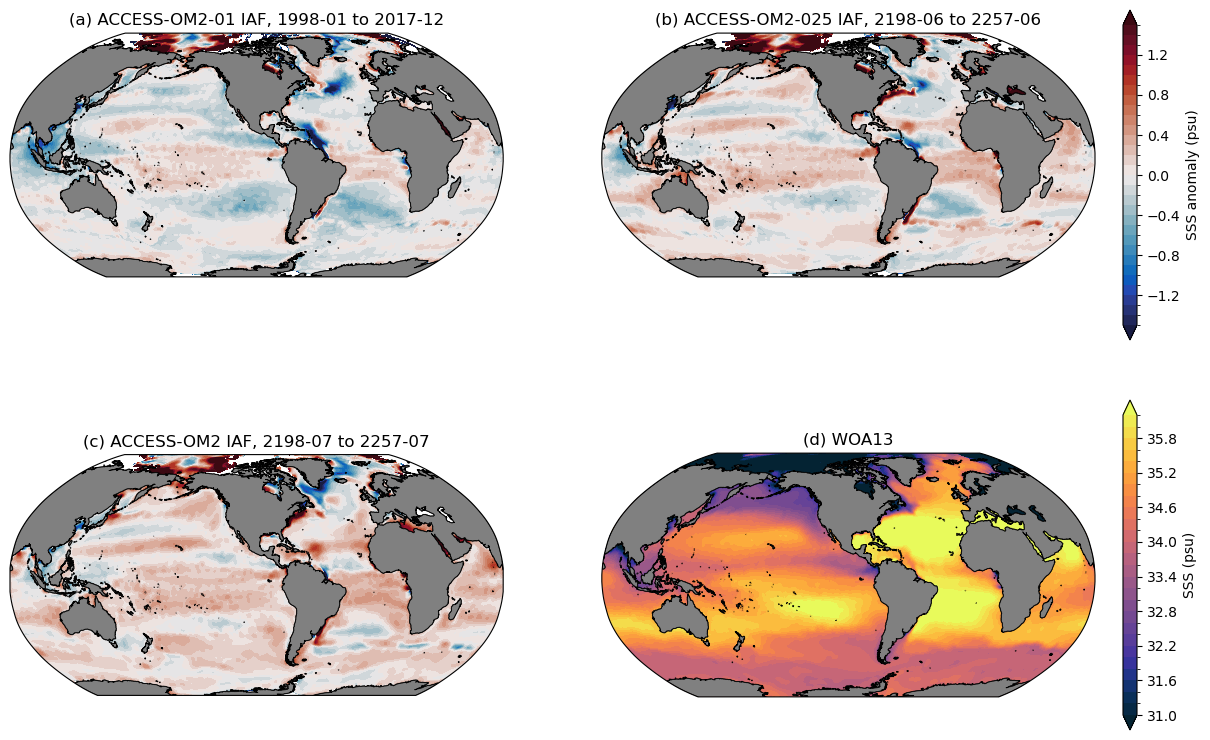

In [12]:
fig = plt.figure(figsize=(14, 10))
ekeys = ['01degIAF', '025degIAF', '1degIAF']
plot_SSS(ekeys)

## Equatorial Pacific Temperature and Salinity Longitude-depth biases

Our final example compares temperature and salinity biases in the tropical Pacific (note, this overlaps somewhat with the `Equatorial_thermal_and_zonal_velocity_structure.ipynb` documented example).

We follow the same procedure as before, first loading the data.

In [ ]:
# Define list of experiments to load (useful for testing):
ekeys = ['1degIAF', '025degIAF', '01degIAF']

# Loop through models
for ekey in ekeys:
    e = exptdict[ekey]
    
    # Load temperature
    eq_temp = cc.querying.getvar(e['expt'], 'temp',session_cc,
                 n=e['n_files'], ncfile='ocean.nc',
                 start_time=e['itime'], end_time=e['ftime']).sel(yt_ocean=0, method='nearest')

    # convert MOM time to datetime:
    tstart = datetime.datetime.fromtimestamp(eq_temp.time.item(0) * 1e-9)
    tend = datetime.datetime.fromtimestamp(eq_temp.time.item(-1) * 1e-9)
    
    # Set a text string to add the year range in title.
    e['yearrange'] = "{} to {}".format(tstart.strftime("%Y-%m"), tend.strftime("%Y-%m"),)
    print(f"{ekey}: {e['yearrange']}")

    # Extract the WOA13 data
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning)
        e['eq_temp_WOA13'] = cc.querying.getvar(e['WOA13expt'], 'temp', session_woa).sel(GRID_Y_T=0., method='nearest').mean('time')
    
    # Calculate the bias
    eq_temp_anom = eq_temp.mean('time') - 273.15 - e['eq_temp_WOA13'].values
    eq_temp_anom.attrs['units'] = 'degrees Celsius'
    
    e['eq_temp_anom'] = eq_temp_anom.load()
    
    # Do salt as for temperature above
    eq_salt = cc.querying.getvar(e['expt'], 'salt',session_cc,
                                 n=e['n_files'], ncfile='ocean.nc',
                                 start_time=e['itime'], end_time=e['ftime']).sel(yt_ocean=0, method='nearest')
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning)
        e['eq_salt_WOA13'] = cc.querying.getvar(e['WOA13expt'], 'salt',session_woa).sel(GRID_Y_T=0.,method='nearest').mean('time')
    eq_salt_anom = eq_salt.mean('time') - e['eq_salt_WOA13'].values
    e['eq_salt_anom'] = eq_salt_anom.load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3

1degIAF: 2198-07 to 2257-07


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/coding/times.py:832: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/coding/times.py:832: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/indexing.py:560: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_du

025degIAF: 2198-06 to 2257-06


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/coding/times.py:832: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/coding/times.py:832: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/coding/times.py:832: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_da

01degIAF: 1998-01 to 2017-12


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/coding/times.py:832: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/coding/times.py:832: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/indexing.py:560: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_du

Then plotting equatorial plots of temperature biases

In [14]:
# Define a function to plot Equatorial Slices of temperature:
def plot_eqtemp(ekeys):
    
    # Define contour levels
    clev = np.arange(-3.,3.25,0.25)

    # Loop through models
    for i, ekey in enumerate(ekeys):
        e = exptdict[ekey]
        ax1 = plt.subplot(int(np.ceil(len(ekeys)/2)), 2, i+1)
        
        # Plot bias as color
        pn = e['eq_temp_anom'].plot.contourf(cmap='bwr', levels=clev, add_colorbar=False, yincrease=False)
        
        # Plot WOA13 isotherms (and 20C bold)
        CS = e['eq_temp_WOA13'].plot.contour(levels=np.arange(0, 32, 2), colors='k')
        ax1.clabel(CS, inline=False, fmt='%d', fontsize=15)
        e['eq_temp_WOA13'].plot.contour(levels=[20.], colors='k', linewidths=3.)
        (e['eq_temp_anom'] + e['eq_temp_WOA13'].values).plot.contour(levels=[20.], colors='k',
                                                                     linewidths=3., linestyles='--')
        
        # Add annotations
        plt.title("({}) {}, {}".format(chr(ord('a') + i), e['model'], e['yearrange']))
        ax1.set_ylim([300., 0.])
        ax1.set_xlim([-220., -80.])
        ax1.set_ylabel('Depth (m)')
        ax1.set_xlabel('Longitude ($^\circ$E)')
        
        if i == 0:
            ax1.text(-210., 275., 'WOA13 Isotherms', fontsize=15)
            p0 = pn

    ax5 = plt.axes([0.92, 0.2, 0.01, 0.5])
    cb = plt.colorbar(p0, cax=ax5, orientation='vertical')
    cb.ax.set_ylabel('Temperature anomaly (°C)')

Plot temperature comparison of IAF simulations.

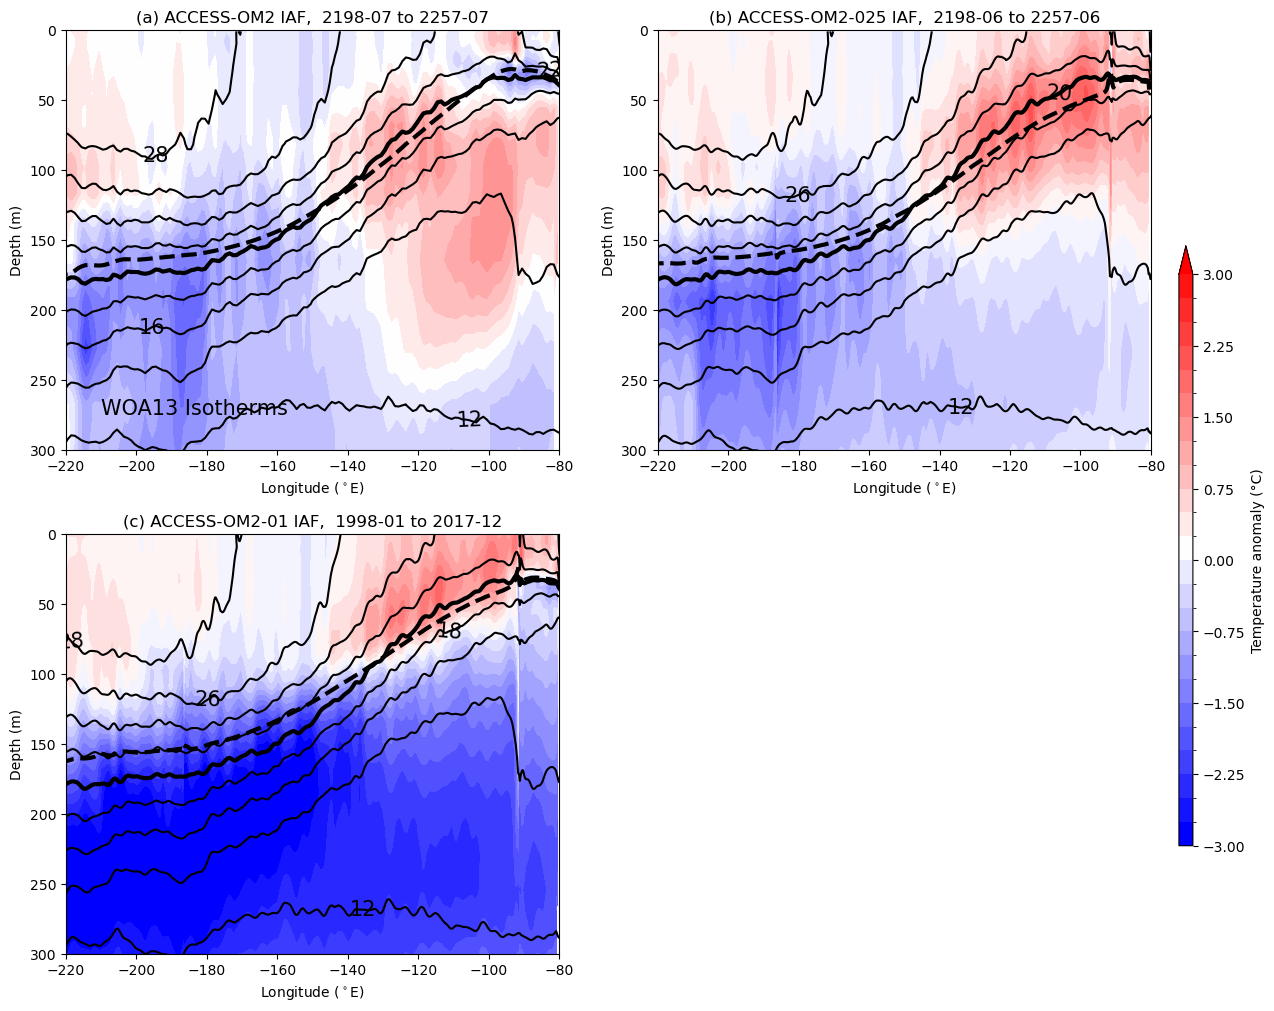

In [15]:
fig = plt.figure(figsize=(14, 12))
ekeys = ['1degIAF', '025degIAF', '01degIAF']
plot_eqtemp(ekeys)

And finally, repeat the same for salinity.

In [16]:
# Define a function to plot Equatorial Slices of salinity
def plot_eqsalt(ekeys):
    
    # Define contour levels
    clev = np.arange(-1., 1.1, 0.1)

    # Loop through models
    for i, ekey in enumerate(ekeys):
        e = exptdict[ekey]
        ax1 = plt.subplot(int(np.ceil(len(ekeys)/2)), 2, i+1)
        
        # Plot bias as color
        pn = e['eq_salt_anom'].plot.contourf(cmap='bwr', levels=clev, add_colorbar=False, yincrease=False)
        
        # Plot WOA13 salinity (and 20C bold)
        CS = e['eq_salt_WOA13'].plot.contour(levels=np.arange(30., 36.1, 0.1), colors='k')
        ax1.clabel(CS, inline=False, fmt='%3.2f', fontsize=15)
        
        # Add annotations
        plt.title("({}) {}, {}".format(chr(ord('a') + i), e['model'], e['yearrange']))
        ax1.set_ylim([300., 0.])
        ax1.set_xlim([-220., -80.])
        ax1.set_ylabel('Depth (m)')
        ax1.set_xlabel('Longitude ($^\circ$E)')
        
        if i == 0:
            ax1.text(-210., 275., 'WOA13 Isohalines', fontsize=15)
            p0 = pn

    ax5 = plt.axes([0.92, 0.2, 0.01, 0.5])
    cb = plt.colorbar(p0, cax=ax5, orientation='vertical')
    cb.ax.set_ylabel('Salinity anomaly (psu)')

Plot salinity comparisson for IAF simulations.

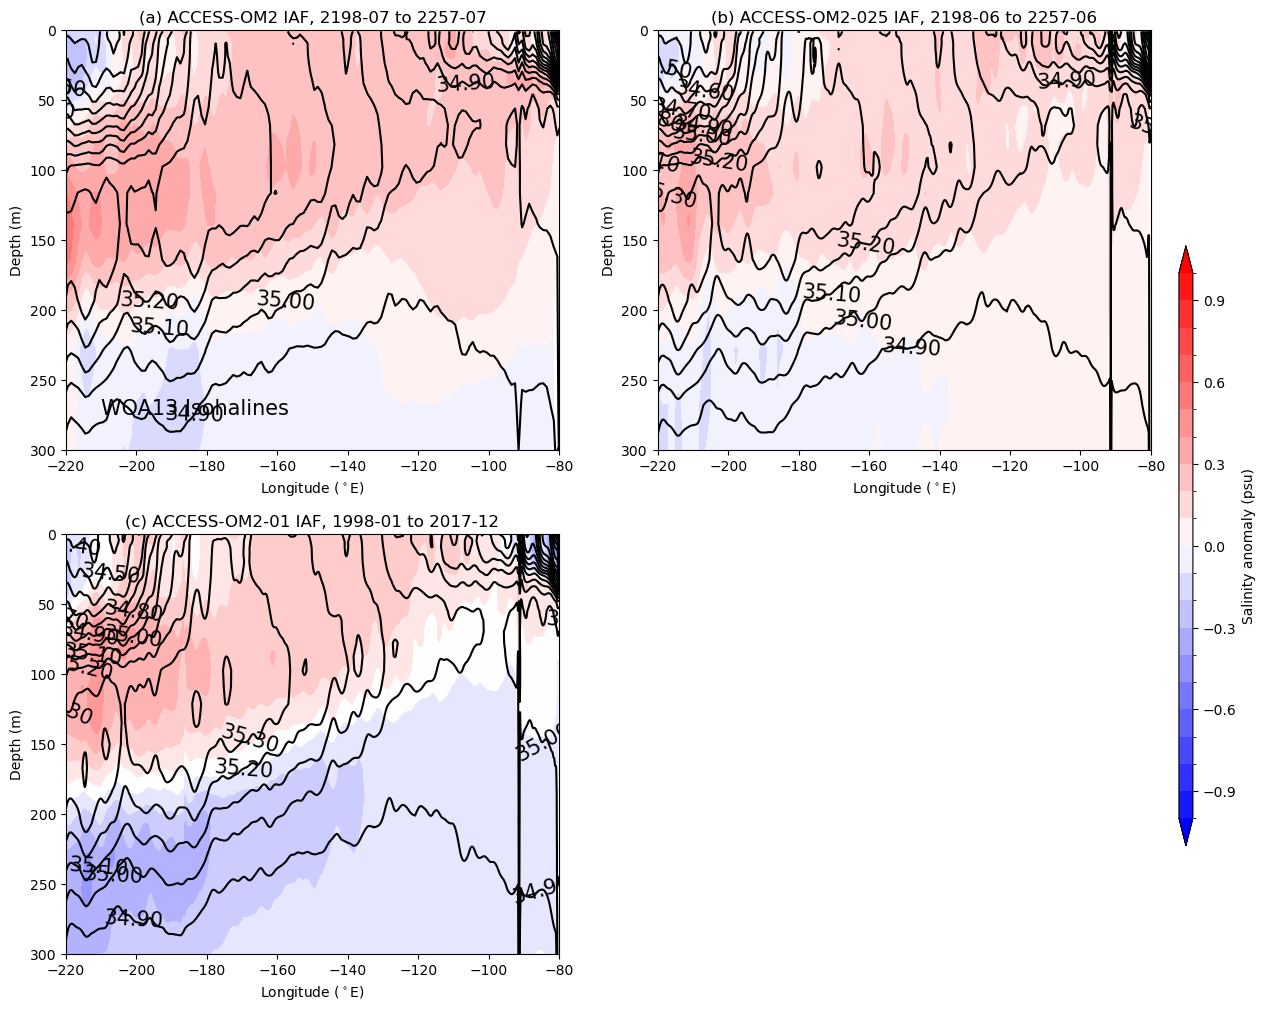

In [17]:
fig = plt.figure(figsize=(14, 12))
ekeys = ['1degIAF', '025degIAF', '01degIAF']
plot_eqsalt(ekeys)